# TFM

## Tabla de contenidos

* [1. Objetivo](#cap1)
    * [1.1. Participantes](#section_1_1)
* [2. Librerías y carga de datos](#cap2)
* [3. Feature engineering](#cap3)
* [4. EDA](#cap4)
    * [4.1. EDA reddit](#section_4_1)
    * [4.2. EDA precio GME](#section_4_1)
* [5. Análisis sentimientos](#cap5)
    * [5.1. Clasificación sentimientos títulos](#section_5_1)
        * [5.1.1. Modelo BERT](#section_5_1_1)
        * [5.1.2. Librería NLTK](#section_5_1_2)
    * [5.2. Clasificación sentimientos post](#section_5_2)
        * [5.2.1. Modelo BERT](#section_5_2_1)
        * [5.2.2. Librería NLTK](#section_5_2_2)
    * [5.3. Análisis relación sentimientos y precios de la acción](#section_5_3)
        * [Section 1.2.1](#section_1_2_1)
        * [Section 1.2.2](#section_1_2_2)
        * [Section 1.2.3](#section_1_2_3)
* [6. Análisis sentimientos post](#cap6)
* [7. Conclusiones](#cap7)

## 1. Objetivo <a class="anchor" id="cap1"></a>

Este proyecto tiene como propósito que los estudiantes identifiquen un problema abierto en el área del análisis de datos apoyado por técnicas de Inteligencia Artificial en el ámbito de su preferencia (Educación, ambiente, criminología, gobierno, etc.). Una vez identificado el problema el estudiante aplicará los conocimientos y competencias, vistos y adquiridos en el Master para hacer un tratamiento de datos al nivel que escoja (Descriptivo, diagnóstico, predictivo, prescriptivo).

### 1.1. Participantes <a class="anchor" id="section_1_1"></a>

* Mireya Harillo Gámez
* Óscar Tienda Beteta
* Henry Ocaña Luna
* David de la Torre Amengual

## 2. Librerías y carga de datos <a class="anchor" id="cap2"></a>

In [1]:
!pip install mplfinance
!pip install transformers

In [121]:
import numpy as np
import pandas as pd # Tratamiento de datos en formato tabular
import matplotlib.pyplot as plt #Visualizaciones
%matplotlib inline
from matplotlib.pyplot import figure
import seaborn as sns # Visualizaciónes
import IPython # Leer imágenes desde URL
import mplfinance as mpf #Gráficos de velas
import torch 
#import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os.path # Comprobación de existencia de ficheros
from datetime import datetime # Consultar fecha actual
import nltk
#nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re # Tratamiento de expresiones regulares

Instalamos librerias para análisis de sentimientos.

A continuación cargamos los datos de reddit con los que vamos a trabajar y mostramos una porción.

In [3]:
reddit_raw_dataset = pd.read_csv('https://raw.githubusercontent.com/david-dlta/recursosTFM/main/reddit_wsb.csv')
reddit_raw_dataset.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


Hacemos lo mismo con los datos de los precios de las acciones de GameStop Corp. (GME).

In [4]:
gme_raw_dataset = pd.read_csv('https://raw.githubusercontent.com/david-dlta/recursosTFM/main/GME_price.csv')
gme_raw_dataset.head()

,Date,Close,Volume,Open,High,Low
0,08/20/2021,159.30,1154858,153.80,160.0900,153.2400
1,08/19/2021,152.90,1196548,156.77,157.9899,150.7800
2,08/18/2021,157.05,1411842,163.25,165.6000,156.7500
3,08/17/2021,163.55,1215938,161.19,169.4800,161.1000
4,08/16/2021,163.93,1574877,161.00,169.8799,159.1601


## 3. Feature engineering <a class="anchor" id="cap3"></a>

Los datos con los que contamos de partida en el dataset no se ajustan totalmente a las nuestras necesidades. Por ello debemos realizar algunas transformaciones sobre estos para poder llevar a cabo el proyecto.

Creamos tres atributos nuevos partiendo del atributo *timestamp*.

In [5]:
reddit_dataset = reddit_raw_dataset.copy()

reddit_dataset['date'] = pd.to_datetime(reddit_raw_dataset['timestamp']).dt.date
reddit_dataset['year'] = pd.to_datetime(reddit_raw_dataset['timestamp']).dt.year
reddit_dataset['month'] = pd.to_datetime(reddit_raw_dataset['timestamp']).dt.month
reddit_dataset['day'] = pd.to_datetime(reddit_raw_dataset['timestamp']).dt.day
#reddit_dataset['timestamp'] = reddit_dataset.rename(columns={'timestamp': 'date'})

reddit_dataset

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41,2021-01-28,2021,1,28
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10,2021-01-28,2021,1,28
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,2021-01-28,2021,1,28
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57,2021-01-28,2021,1,28
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56,2021-01-28,2021,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...
52106,Everything I've learned about being on Wall St...,1011,od9xfn,https://v.redd.it/dfkjjyjae3971,87,1.625359e+09,NaN,2021-07-04 03:43:04,2021-07-04,2021,7,4
52107,I Accidentally YOLOed Half My Portfolio After ...,510,od97ek,https://www.reddit.com/r/wallstreetbets/commen...,288,1.625357e+09,tl;dr at bottom\n\nSo after using DD from [u/C...,2021-07-04 02:55:38,2021-07-04,2021,7,4
52108,$53k TO $306K in just 2 days.,1190,od7008,https://i.redd.it/k0pkc2m4i2971.png,237,1.625349e+09,NaN,2021-07-04 00:42:06,2021-07-04,2021,7,4
52109,Average Annual Return on Investments for WSB,74,od77kx,https://www.reddit.com/r/wallstreetbets/commen...,194,1.625349e+09,I was having a discussion with my friends abou...,2021-07-04 00:54:20,2021-07-04,2021,7,4


In [6]:
gme_dataset = gme_raw_dataset.copy()

gme_raw_dataset['Date'] = pd.to_datetime(gme_raw_dataset['Date'])

gme_dataset['week_day'] = gme_raw_dataset['Date'].dt.day_name()

gme_dataset

,Date,Close,Volume,Open,High,Low,week_day
0,08/20/2021,159.30,1154858,153.80,160.0900,153.2400,Friday
1,08/19/2021,152.90,1196548,156.77,157.9899,150.7800,Thursday
2,08/18/2021,157.05,1411842,163.25,165.6000,156.7500,Wednesday
3,08/17/2021,163.55,1215938,161.19,169.4800,161.1000,Tuesday
4,08/16/2021,163.93,1574877,161.00,169.8799,159.1601,Monday
...,...,...,...,...,...,...,...
247,08/27/2020,5.25,3384658,5.11,5.3799,5.0200,Thursday
248,08/26/2020,5.11,2779664,4.97,5.2200,4.9199,Wednesday
249,08/25/2020,4.98,2998678,4.88,5.2500,4.8800,Tuesday
250,08/24/2020,4.87,4585366,5.10,5.1300,4.5600,Monday


## 4. EDA <a class="anchor" id="cap4"></a>

### 4.1. EDA reddit <a class="anchor" id="section_4_1"></a>


In [7]:
reddit_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52111 entries, 0 to 52110
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      52111 non-null  object 
 1   score      52111 non-null  int64  
 2   id         52111 non-null  object 
 3   url        52111 non-null  object 
 4   comms_num  52111 non-null  int64  
 5   created    52111 non-null  float64
 6   body       24236 non-null  object 
 7   timestamp  52111 non-null  object 
 8   date       52111 non-null  object 
 9   year       52111 non-null  int64  
 10  month      52111 non-null  int64  
 11  day        52111 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 4.8+ MB


Comprobamos de forma visual el número de registros nulos de los atributos del dataset.

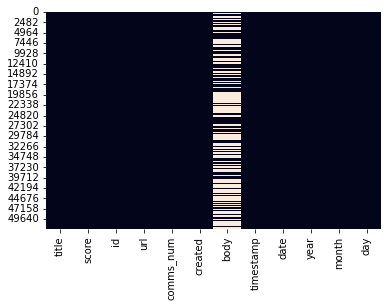

In [8]:
sns.heatmap(reddit_dataset.isnull(), cbar=False)
plt.show()

Podemos observar que la columna *body* tiene un gran número de registros nulos. Vamos a centrarnos en esta varaible apra identificar que esta sucediendo.

In [9]:
reddit_dataset[reddit_dataset['body'].isna()]

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41,2021-01-28,2021,1,28
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10,2021-01-28,2021,1,28
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57,2021-01-28,2021,1,28
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56,2021-01-28,2021,1,28
5,WE BREAKING THROUGH,405,l6uf7d,https://i.redd.it/2wef8tc062e61.png,84,1.611862e+09,NaN,2021-01-28 21:26:30,2021-01-28,2021,1,28
...,...,...,...,...,...,...,...,...,...,...,...,...
52102,Pro moves,22537,ode6ey,https://i.redd.it/c39slsudv4971.jpg,352,1.625377e+09,NaN,2021-07-04 08:39:57,2021-07-04,2021,7,4
52103,Root Inc. (ROOT) Just Entered My Buy Zone. Int...,83,odcvds,https://i.redd.it/ufse5osed4971.png,130,1.625371e+09,NaN,2021-07-04 07:04:30,2021-07-04,2021,7,4
52104,$3.2k -> $37.8k in 1 day on SPCE $45c FDs,1341,odc0nu,https://i.redd.it/yij40o9u34971.png,305,1.625368e+09,NaN,2021-07-04 06:06:08,2021-07-04,2021,7,4
52106,Everything I've learned about being on Wall St...,1011,od9xfn,https://v.redd.it/dfkjjyjae3971,87,1.625359e+09,NaN,2021-07-04 03:43:04,2021-07-04,2021,7,4


Seleccionamos una de las URL para ver si nos da más información.

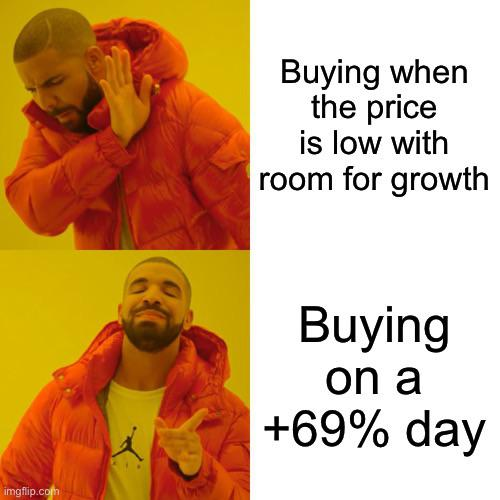

In [10]:
IPython.display.Image('https://i.redd.it/c39slsudv4971.jpg', width = 250)

A parte de imágenes, las URL de los registros que tienen la variable *body* nula, contienen videos, documentos y otros archivos multimedia. Esa es la razón por la que el cuerpo del post es nulo. Cuando realicemos el análisis sentimental del cuerpo del post deberemos eliminar estos registros. Pero no los descartaremos cuando analicemos el sentimiento de los titulos de los posts.

A continuación vamos a extraer información descriptiva de los datos. Con el parámetro *include = 'all'* especificamos que queremos información de todos los atributos del dataset, incluso si no son numéricos.

In [11]:
reddit_dataset.describe(include='all')

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day
count,52111,52111.000000,52111,52111,52111.000000,5.211100e+04,24236,52111,52111,52111.000000,52111.000000,52111.000000
unique,50983,NaN,52111,52096,NaN,NaN,23702,42384,158,NaN,NaN,NaN
top,AMC,NaN,lxlr7r,https://magic.freetrade.io/join/jamie/13edb513,NaN,NaN,Your daily trading discussion thread. Please k...,2021-01-29 01:03:59,2021-01-29,NaN,NaN,NaN
freq,40,NaN,1,11,NaN,NaN,74,14,15694,NaN,NaN,NaN
mean,NaN,1392.054825,NaN,NaN,258.724550,1.614303e+09,NaN,NaN,NaN,2020.999981,2.296866,17.674694
std,NaN,8065.440508,NaN,NaN,2540.474545,3.733101e+06,NaN,NaN,NaN,0.004381,1.534253,11.042699
min,NaN,0.000000,NaN,NaN,0.000000,1.601340e+09,NaN,NaN,NaN,2020.000000,1.000000,1.000000
25%,NaN,1.000000,NaN,NaN,3.000000,1.611882e+09,NaN,NaN,NaN,2021.000000,1.000000,6.000000
50%,NaN,36.000000,NaN,NaN,17.000000,1.612479e+09,NaN,NaN,NaN,2021.000000,2.000000,19.000000
75%,NaN,205.000000,NaN,NaN,58.000000,1.615066e+09,NaN,NaN,NaN,2021.000000,3.000000,29.000000


In [12]:
reddit_dataset.head()

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41,2021-01-28,2021,1,28
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10,2021-01-28,2021,1,28
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,2021-01-28,2021,1,28
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57,2021-01-28,2021,1,28
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56,2021-01-28,2021,1,28


Vamos a explorar cual es la cantidad de posts que se han realizado en función de la fecha.

In [13]:
posts_fecha = reddit_dataset.groupby(['date']).size().reset_index(name='counts')

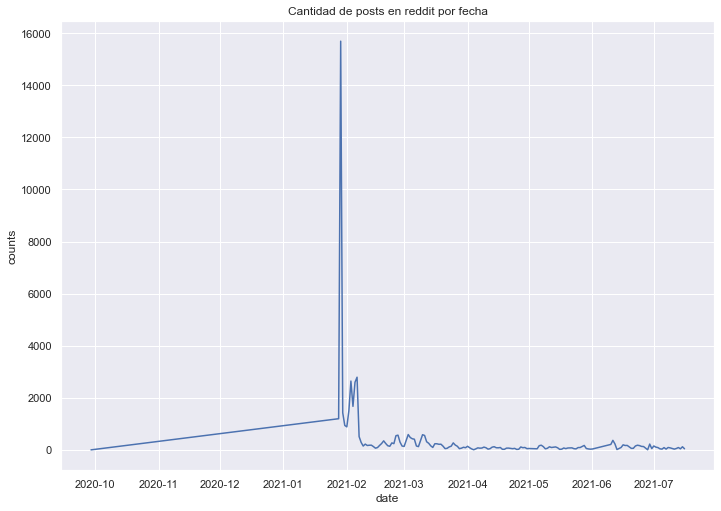

In [14]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.lineplot(data=posts_fecha, x='date', y='counts').set_title('Cantidad de posts en reddit por fecha')

plt.show()

Vamos a explorar la puntuación media recibida en los posts en función de la fecha.

In [15]:
#score_fecha = reddit_dataset.groupby(['date']).size().reset_index(name='counts')

score_fecha = reddit_dataset[['score','date']].groupby(['date']).mean().reset_index()

score_fecha

,date,score
0,2020-09-29,4.000000
1,2021-01-28,960.609023
2,2021-01-29,408.457309
3,2021-01-30,4618.594101
4,2021-01-31,5230.513312
...,...,...
153,2021-07-12,713.754717
154,2021-07-13,779.956044
155,2021-07-14,1263.268293
156,2021-07-15,725.500000


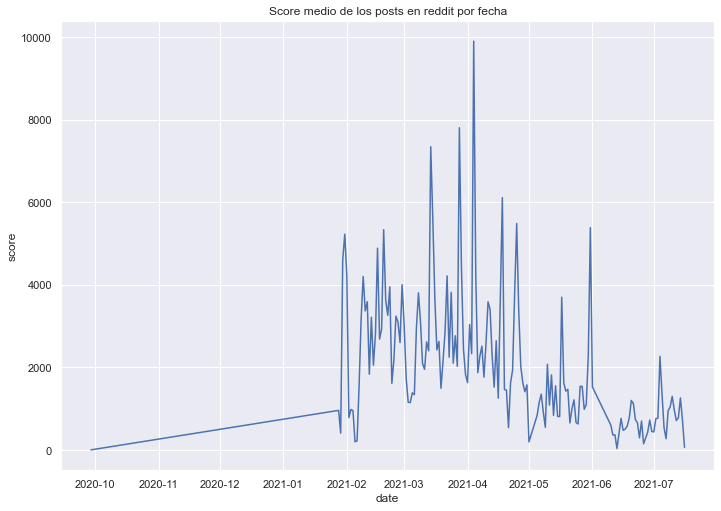

In [16]:
sns.lineplot(data=score_fecha, x='date', y='score').set_title('Score medio de los posts en reddit por fecha')

plt.show()

Vamos a explorar si la longitud del titulo o del cuerpo de los posts tienen relación con la puntuación de estos.

In [17]:
reddit_dataset.head(3)

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41,2021-01-28,2021,1,28
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10,2021-01-28,2021,1,28
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35,2021-01-28,2021,1,28


In [18]:
score_length=pd.DataFrame()
score_length['score'] = reddit_dataset['score']
score_length['title_len'] = pd.DataFrame(reddit_dataset['title'].str.len())

score_length['body_len'] = pd.DataFrame(reddit_dataset['body'].str.len())
score_length['comms_num'] = reddit_dataset['comms_num']

score_length

,score,title_len,body_len,comms_num
0,55,59,NaN,6
1,110,80,NaN,23
2,0,15,1319.0,47
3,29,75,NaN,74
4,71,79,NaN,156
...,...,...,...,...
52106,1011,59,NaN,87
52107,510,54,2169.0,288
52108,1190,29,NaN,237
52109,74,44,994.0,194


Reemplazamos los registros con valor *nan* en la columna *body_len* por 0.

In [19]:
score_length.fillna(0)

,score,title_len,body_len,comms_num
0,55,59,0.0,6
1,110,80,0.0,23
2,0,15,1319.0,47
3,29,75,0.0,74
4,71,79,0.0,156
...,...,...,...,...
52106,1011,59,0.0,87
52107,510,54,2169.0,288
52108,1190,29,0.0,237
52109,74,44,994.0,194


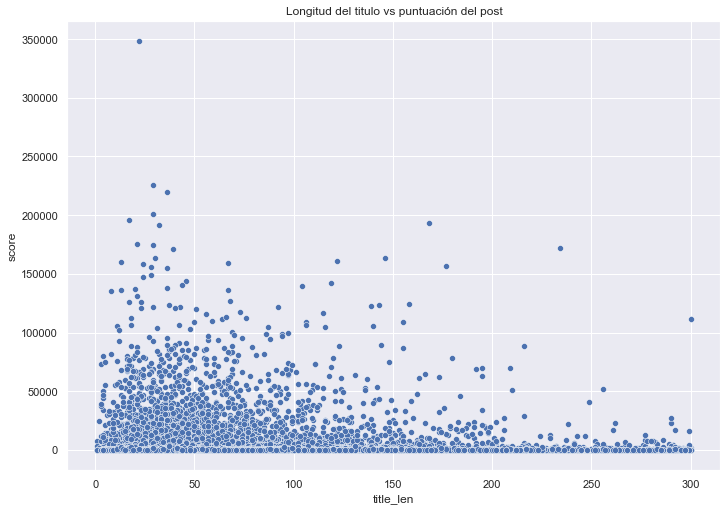

In [20]:
sns.scatterplot(data=score_length, x='title_len', y='score').set_title('Longitud del titulo vs puntuación del post')

plt.show()

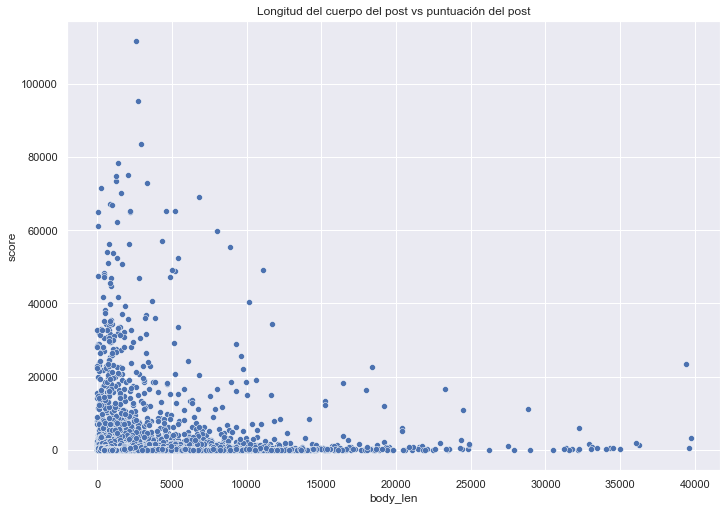

In [21]:
sns.scatterplot(data=score_length, x='body_len', y='score').set_title('Longitud del cuerpo del post vs puntuación del post')

plt.show()

Con el mismo dataset que hemos generado vamos a explorar si la puntuación del post tiene relación con el número de comentarios. 

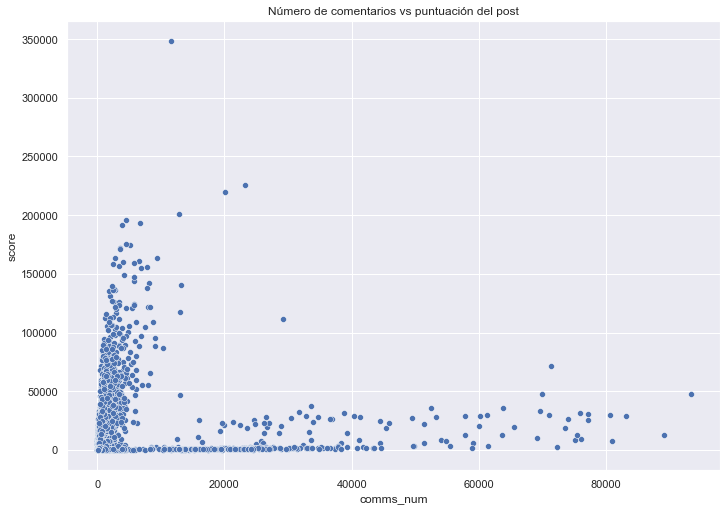

In [22]:
sns.scatterplot(data=score_length, x='comms_num', y='score').set_title('Número de comentarios vs puntuación del post')

plt.show()

También vamos a estudiar la distribución de comentarios de los posts

C:\Users\david\Anaconda3\envs\Env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


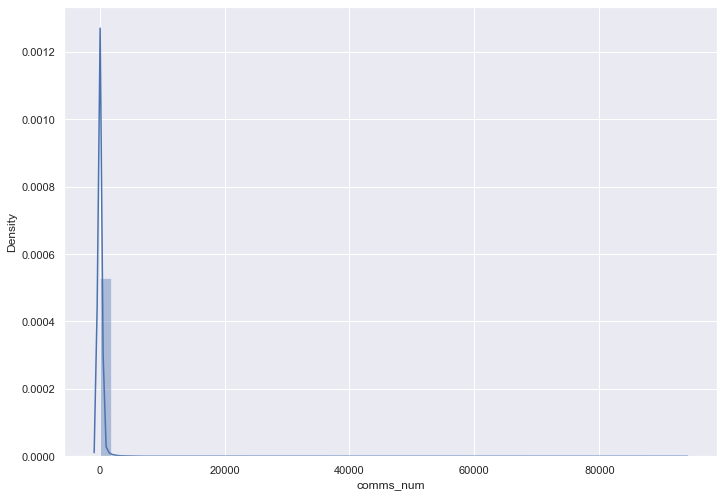

In [23]:
sns.distplot(score_length['comms_num'])

plt.show()

También vamos a estudiar la distribución de las puntuaciones de los posts

C:\Users\david\Anaconda3\envs\Env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


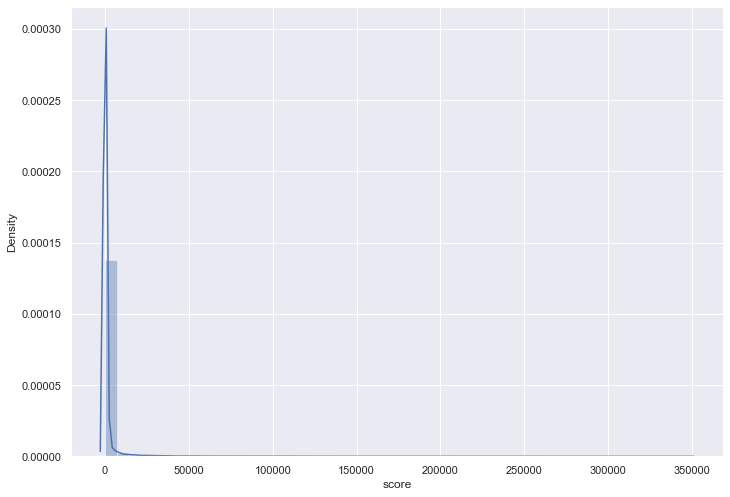

In [24]:
sns.distplot(score_length['score'])

plt.show()

### 4.2. EDA precio GME <a class="anchor" id="section_4_2"></a>

In [25]:
gme_dataset.head(5)

,Date,Close,Volume,Open,High,Low,week_day
0,08/20/2021,159.30,1154858,153.80,160.0900,153.2400,Friday
1,08/19/2021,152.90,1196548,156.77,157.9899,150.7800,Thursday
2,08/18/2021,157.05,1411842,163.25,165.6000,156.7500,Wednesday
3,08/17/2021,163.55,1215938,161.19,169.4800,161.1000,Tuesday
4,08/16/2021,163.93,1574877,161.00,169.8799,159.1601,Monday


In [26]:
gme_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      252 non-null    object 
 1   Close     252 non-null    float64
 2   Volume    252 non-null    int64  
 3   Open      252 non-null    float64
 4   High      252 non-null    float64
 5   Low       252 non-null    float64
 6   week_day  252 non-null    object 
dtypes: float64(4), int64(1), object(2)
memory usage: 13.9+ KB


Vamos a convertir el tipo de datos de la columna *date* a tipo *datetime*, esto nos facilitará tratar con este campo posteriormente.

In [27]:
gme_dataset['Date'] = pd.to_datetime(gme_dataset['Date'], format='%m/%d/%Y')

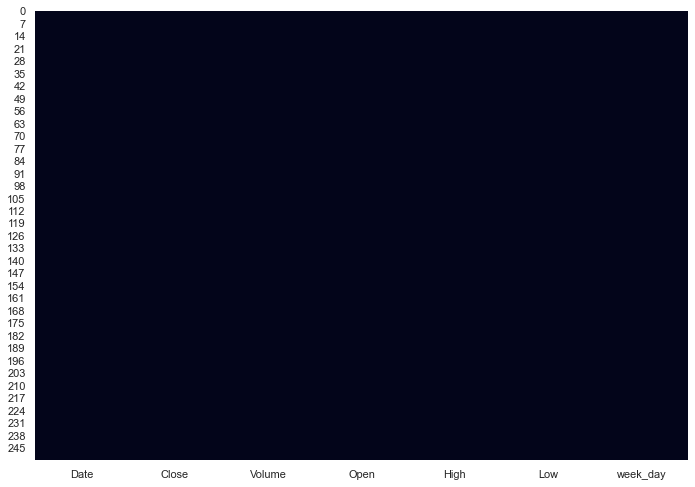

In [28]:
sns.heatmap(gme_dataset.isnull(), cbar=False)
plt.show()

Podemos observar que el dataset no contiene valores nulos.

Vamos a detallar más la información de cada una de las variables para hacernos una mejor idea de estas.

In [29]:
gme_dataset.describe(include='all')

C:\Users\david\AppData\Local\Temp/ipykernel_14416/1064862866.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  gme_dataset.describe(include='all')


,Date,Close,Volume,Open,High,Low,week_day
count,252,252.000000,2.520000e+02,252.000000,252.000000,252.000000,252
unique,252,NaN,NaN,NaN,NaN,NaN,5
top,2021-03-03 00:00:00,NaN,NaN,NaN,NaN,NaN,Tuesday
freq,1,NaN,NaN,NaN,NaN,NaN,52
first,2020-08-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2021-08-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,105.981032,1.765364e+07,107.189393,115.542853,98.646604,NaN
std,NaN,89.901321,2.841126e+07,92.004999,100.110119,83.534723,NaN
min,NaN,4.870000,9.454280e+05,4.600000,5.130000,4.560000,NaN
25%,NaN,13.790000,4.344478e+06,13.682500,14.293750,13.072500,NaN


Vamos a explorar los precios de apertura en función de la fecha.

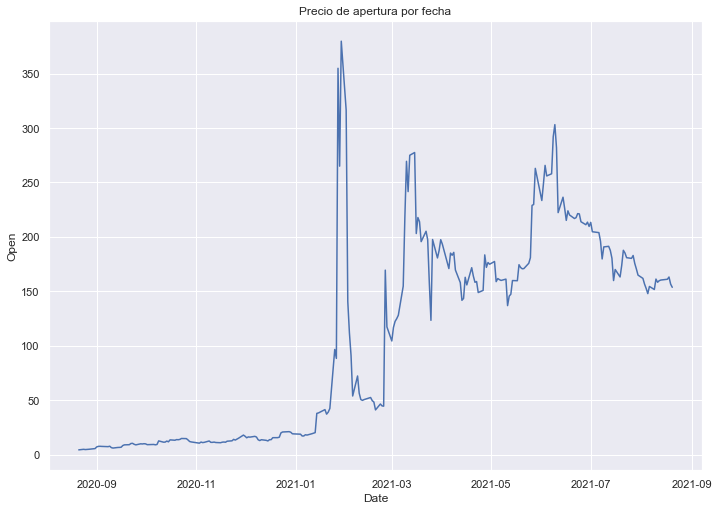

In [30]:
sns.lineplot(data=gme_dataset, x='Date', y='Open').set_title('Precio de apertura por fecha')

plt.show()

Pero el precio de apertura únicamente no nos aporta mucho valor. En economía se suele utilizar muy comunmente un tipo de gráficos llamado *velas japonesas*, que permiten representar en un formato muy compacto el precio de apertura de la acción, el precio de cierre, el precio máximo que ha alcanzado la acción y el precio mínimo. De esta manera maximizamos el valor que el gráfico nos puede ofrecer, incluso representando si la acción ha tenido un precio de cierre inferior o superior al precio de apertura mediante colores. 

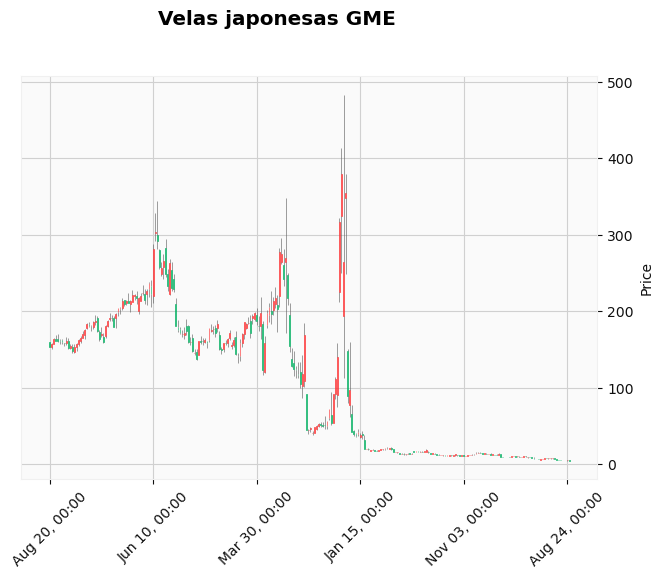

In [31]:
gme_dataset_candles = gme_dataset.copy()
gme_dataset_candles = gme_dataset_candles.set_index('Date')

mpf.plot(data = gme_dataset_candles,
         type = 'candle',
         style = 'yahoo',
         title = 'Velas japonesas GME'
)

El orden de los registros es inverso al tiempo por lo que debemos cambiar el orden de todos los registros del dataset. LEl primer registro será el último y el último registro sera el primero.

In [32]:
gme_dataset_candles = gme_dataset_candles.iloc[::-1]

gme_dataset_candles

,Close,Volume,Open,High,Low,week_day
Date,,,,,,
2020-08-21,5.03,10642590,4.60,5.6000,4.5950,Friday
2020-08-24,4.87,4585366,5.10,5.1300,4.5600,Monday
2020-08-25,4.98,2998678,4.88,5.2500,4.8800,Tuesday
2020-08-26,5.11,2779664,4.97,5.2200,4.9199,Wednesday
2020-08-27,5.25,3384658,5.11,5.3799,5.0200,Thursday
...,...,...,...,...,...,...
2021-08-16,163.93,1574877,161.00,169.8799,159.1601,Monday
2021-08-17,163.55,1215938,161.19,169.4800,161.1000,Tuesday
2021-08-18,157.05,1411842,163.25,165.6000,156.7500,Wednesday


Volvemos a generar el gráfico de velas japonesas.

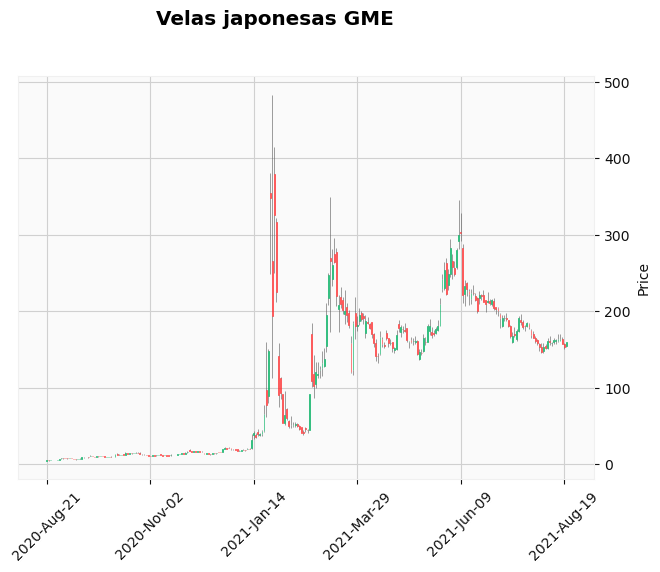

In [33]:
mpf.plot(data = gme_dataset_candles,
         type = 'candle',
         style = 'yahoo',
         title = 'Velas japonesas GME'
)

## 5. Análisis sentimientos <a class="anchor" id="cap5"></a>

### 5.1. Clasificación sentimientos títulos <a class="anchor" id="section_5_1"></a>

#### 5.1.1. Modelo BERT <a class="anchor" id="section_5_1_1"></a>

In [34]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model_BERT = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Vamos a analizar un título individualmente. 

In [35]:
reddit_dataset['title'].iloc[1]

'Math Professor Scott Steiner says the numbers spell DISASTER for Gamestop shorts'

El primer paso es tokenizar el texto que queramos analizar. El codificador nos devuelve una lista de la codificación del texto que le pasamos por parámetro.

In [36]:
tokens = tokenizer.encode_plus(
    reddit_dataset['title'].iloc[1],
    add_special_tokens = True,
    return_tensors = 'pt'
)

tokens['input_ids'][0]

tensor([  101, 33508, 12156, 13064, 39241, 20782, 10103, 18627, 55759, 41055,
        10139, 12052, 33876, 12972, 10107,   102])

Con el texto codificado podemos alimentar el modelo. El modelo nos devuelve otra lista, logits, con 5 valores que representan la probabilidad de que el texto que estamos analizando tenga un sentimiento negativo - negativo/neutro - neutro - positivo/neutro - positivo, respectivamente. El valor máximo de la la lista nos indicará cual es el sentimiento predominante del texto analizado.

In [37]:
result = model_BERT(tokens['input_ids'])

result

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.8411,  0.8529,  0.3576, -0.5118, -1.3356]],
       grad_fn=<AddmmBackward>), hidden_states=None, attentions=None)

En el ejemplo podemos ver que para el texto analizado el modelo nos devuelve un sentimiento predominante negativo/neutro.

Para poder extraer el sentimiento predominante de todos los títulos vamos a crear una función que ejecutaremos para cada registro del dataset. La función realizará cada unos de los pasos anteriormente explicados.

In [38]:
def BERT_sentiment_score(texto):
        tokens = tokenizer.encode_plus(texto,add_special_tokens = True,return_tensors = 'pt')
        result = model_BERT(tokens['input_ids'])
        return int(torch.argmax(result.logits))+1 #De los 5 resultados ,que representan las probabilidades del sentimiento del texto, que nos devuelve el modelo nos quedamos con el max

Aplicamos la función para calcular el sentimiento de los títulos con el modelo BERT y lo almacenamos en una nueva variable en el dataset. Para facilitar el desarrollo, y no calcular constantemente el sentimiento de los títulos, una vez generado el sentimiento de los títulos se ha exportado a csv el dataset. Si el csv no se encuentra disponible, sería el caso de una ejecución inicial, se calcularía el sentimiento de los títulos del dataset.

In [39]:
if os.path.isfile('reddit_dataset_BERT_score_title.csv'):
    reddit_dataset = pd.read_csv('reddit_dataset_BERT_score_title.csv', sep=';')
else:
    reddit_dataset['BERT_score_title'] = reddit_dataset['title'].apply(lambda x: BERT_sentiment_score(x[:512]))
    reddit_dataset.to_csv(path_or_buf = './reddit_dataset_BERT_score_title.csv', index=False) # Guardamos el estado actual del dataset en formato CVS para no tener qu replicarlo en cada ejecucion
    
reddit_dataset

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day,BERT_score_title
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6.0,1.611863e+10,NaN,28/01/2021 21:37,28/01/2021,2021.0,1.0,28.0,1.0
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23.0,1.611862e+10,NaN,28/01/2021 21:32,28/01/2021,2021.0,1.0,28.0,2.0
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47.0,1.611862e+10,The CEO of NASDAQ pushed to halt trading “to g...,28/01/2021 21:30,28/01/2021,2021.0,1.0,28.0,1.0
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74.0,1.611862e+10,NaN,28/01/2021 21:28,28/01/2021,2021.0,1.0,28.0,5.0
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156.0,1.611862e+10,NaN,28/01/2021 21:26,28/01/2021,2021.0,1.0,28.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52135,Everything I've learned about being on Wall St...,1011,od9xfn,https://v.redd.it/dfkjjyjae3971,87.0,1.625359e+10,NaN,04/07/2021 3:43,04/07/2021,2021.0,7.0,4.0,5.0
52136,I Accidentally YOLOed Half My Portfolio After ...,510,od97ek,https://www.reddit.com/r/wallstreetbets/commen...,288.0,1.625357e+10,tl;dr at bottom\n\nSo after using DD from [u/C...,04/07/2021 2:55,04/07/2021,2021.0,7.0,4.0,1.0
52137,$53k TO $306K in just 2 days.,1190,od7008,https://i.redd.it/k0pkc2m4i2971.png,237.0,1.625349e+10,NaN,04/07/2021 0:42,04/07/2021,2021.0,7.0,4.0,1.0
52138,Average Annual Return on Investments for WSB,74,od77kx,https://www.reddit.com/r/wallstreetbets/commen...,194.0,1.625349e+10,I was having a discussion with my friends abou...,04/07/2021 0:54,04/07/2021,2021.0,7.0,4.0,3.0


#### 5.1.2. Librería NLTK <a class="anchor" id="section_5_1_2"></a>

In [40]:
sid = SIA()

test_nltk_title = reddit_dataset[['title', 'id']].copy()

test_nltk_title['title'] = test_nltk_title.title.astype(str)

#test_nltk_title['sentiments']           = test_nltk_title['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
#test_nltk_title['Positive Sentiment']   = test_nltk_title['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
#test_nltk_title['Neutral Sentiment']    = test_nltk_title['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
#test_nltk_title['Negative Sentiment']   = test_nltk_title['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

In [41]:
#Remove handlers
test_nltk_title.title = test_nltk_title.title.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
test_nltk_title.title = test_nltk_title.title.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
test_nltk_title.title = test_nltk_title.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
test_nltk_title.title = test_nltk_title.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
test_nltk_title.title = test_nltk_title.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

Separamos en columnas diferentes cada uno de los sentimientos estimados para cada título.

Añadimos un termino a cada sentimiento para evitar la situación en la que uno de ellos es igual a cero, tener un valor mínimo nos previene de tener que aplicar una transformación logarítmica en valores cero. 

In [42]:
test_nltk_title['sentiments'] = test_nltk_title['title'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
test_nltk_title['Positivo'] = test_nltk_title['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
test_nltk_title['Neutral'] = test_nltk_title['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
test_nltk_title['Negativo'] = test_nltk_title['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

test_nltk_title

,title,id,sentiments,Positivo,Neutral,Negativo
0,Itnot about the money itabout sendingmessage,l6ulcx,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001
1,Math Professor Scott Steiner says the numbers ...,l6uibd,"{'neg': 0.272, 'neu': 0.728, 'pos': 0.0, 'comp...",0.000001,0.728001,0.272001
2,Exit the system,l6uhhn,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001
3,NEW SEC FILING FOR GME CAN SOMEONE LESS RETARD...,l6ugk6,"{'neg': 0.204, 'neu': 0.658, 'pos': 0.138, 'co...",0.138001,0.658001,0.204001
4,Not to distract from GME just thought our AMC ...,l6ufgy,"{'neg': 0.0, 'neu': 0.881, 'pos': 0.119, 'comp...",0.119001,0.881001,0.000001
...,...,...,...,...,...,...
52135,Everythingve learned about being on Wall Stree...,od9xfn,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001
52136,I Accidentally YOLOed Half My Portfolio After ...,od97ek,"{'neg': 0.255, 'neu': 0.745, 'pos': 0.0, 'comp...",0.000001,0.745001,0.255001
52137,53k TO 306K in just 2 days,od7008,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001
52138,Average Annual Return on Investments for WSB,od77kx,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001


Creamos una función para identificar el sentimiento predomeinante de los títulos y lo almacenamos en una nueva columna. El resultado se codifica con un valor numérico que responde a: sentimiento negativo = 1, sentimiento neutral = 3, sentimiento positivo = 5.

In [43]:
def nltk_sent_predominante(x):       
    if x['Positivo'] > x['Neutral'] and x['Positivo'] > x['Negativo']:
        return 5 # Codificación de sentimiento predominante Positivo
    elif x['Negativo'] > x['Positivo'] and x['Negativo'] > x['Neutral']: 
        return 1 # Codificación de sentimiento predominante Negativo
    else:
        return 3 # Codificación de sentimiento predominante Neutro

test_nltk_title['nltk_score_title'] = test_nltk_title[['Positivo','Neutral', 'Negativo']].apply(nltk_sent_predominante, axis=1)

Unimos el dataset con el scoring de los títulos obtenidos con la librería *NLTK* al dataset *maestro*.

In [44]:
reddit_dataset = reddit_dataset.merge(
    test_nltk_title[['id','nltk_score_title']], 
    how ='left', 
    left_on = 'id', 
    right_on = 'id'
)

reddit_dataset

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day,BERT_score_title,nltk_score_title
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6.0,1.611863e+10,NaN,28/01/2021 21:37,28/01/2021,2021.0,1.0,28.0,1.0,3
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23.0,1.611862e+10,NaN,28/01/2021 21:32,28/01/2021,2021.0,1.0,28.0,2.0,3
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47.0,1.611862e+10,The CEO of NASDAQ pushed to halt trading “to g...,28/01/2021 21:30,28/01/2021,2021.0,1.0,28.0,1.0,3
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74.0,1.611862e+10,NaN,28/01/2021 21:28,28/01/2021,2021.0,1.0,28.0,5.0,3
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156.0,1.611862e+10,NaN,28/01/2021 21:26,28/01/2021,2021.0,1.0,28.0,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52839,Everything I've learned about being on Wall St...,1011,od9xfn,https://v.redd.it/dfkjjyjae3971,87.0,1.625359e+10,NaN,04/07/2021 3:43,04/07/2021,2021.0,7.0,4.0,5.0,3
52840,I Accidentally YOLOed Half My Portfolio After ...,510,od97ek,https://www.reddit.com/r/wallstreetbets/commen...,288.0,1.625357e+10,tl;dr at bottom\n\nSo after using DD from [u/C...,04/07/2021 2:55,04/07/2021,2021.0,7.0,4.0,1.0,3
52841,$53k TO $306K in just 2 days.,1190,od7008,https://i.redd.it/k0pkc2m4i2971.png,237.0,1.625349e+10,NaN,04/07/2021 0:42,04/07/2021,2021.0,7.0,4.0,1.0,3
52842,Average Annual Return on Investments for WSB,74,od77kx,https://www.reddit.com/r/wallstreetbets/commen...,194.0,1.625349e+10,I was having a discussion with my friends abou...,04/07/2021 0:54,04/07/2021,2021.0,7.0,4.0,3.0,3


### 5.2. Clasificación sentimientos posts <a class="anchor" id="section_5_2"></a>

#### 5.2.1 Modelo BERT <a class="anchor" id="section_5_2_1"></a>

De una manera similar aplicamos la función para calcular el sentimiento del cuerpo de los posts con el modelo BERT y lo almacenamos en una nueva variable en el dataset. Para facilitar el desarrollo, y no calcular constantemente el sentimiento de los posts, una vez generado el sentimiento de los posts se ha exportado a csv el dataset. Si el csv no se encuentra disponible, sería el caso de una ejecución inicial, se calcularía el sentimiento de los posts del dataset.

In [45]:
if os.path.isfile('test.csv'):
    BERT_score_body = pd.read_csv('test.csv')
    BERT_score_body = BERT_score_body.rename(columns={'Unnamed: 0': 'Indice'})
else:
    BERT_score_body = reddit_dataset.dropna(subset = ["body"])['body'].apply(lambda x: BERT_sentiment_score(x[:512]))
    BERT_score_body.to_csv(path_or_buf = './test.csv', index=True)
    
BERT_score_body

,Indice,body
0,2,1
1,6,1
2,7,2
3,10,5
4,12,1
...,...,...
24231,52101,1
24232,52105,1
24233,52107,2
24234,52109,2


In [46]:
reddit_dataset = reddit_dataset.merge(
    BERT_score_body, 
    how ='left', 
    left_index = True, 
    right_on = 'Indice'
).reset_index(drop=True)

In [47]:
reddit_dataset

,title,score,id,url,comms_num,created,body_x,timestamp,date,year,month,day,BERT_score_title,nltk_score_title,Indice,body_y
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6.0,1.611863e+10,NaN,28/01/2021 21:37,28/01/2021,2021.0,1.0,28.0,1.0,3,0,NaN
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23.0,1.611862e+10,NaN,28/01/2021 21:32,28/01/2021,2021.0,1.0,28.0,2.0,3,1,NaN
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47.0,1.611862e+10,The CEO of NASDAQ pushed to halt trading “to g...,28/01/2021 21:30,28/01/2021,2021.0,1.0,28.0,1.0,3,2,1.0
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74.0,1.611862e+10,NaN,28/01/2021 21:28,28/01/2021,2021.0,1.0,28.0,5.0,3,3,NaN
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156.0,1.611862e+10,NaN,28/01/2021 21:26,28/01/2021,2021.0,1.0,28.0,3.0,3,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52839,Everything I've learned about being on Wall St...,1011,od9xfn,https://v.redd.it/dfkjjyjae3971,87.0,1.625359e+10,NaN,04/07/2021 3:43,04/07/2021,2021.0,7.0,4.0,5.0,3,52839,NaN
52840,I Accidentally YOLOed Half My Portfolio After ...,510,od97ek,https://www.reddit.com/r/wallstreetbets/commen...,288.0,1.625357e+10,tl;dr at bottom\n\nSo after using DD from [u/C...,04/07/2021 2:55,04/07/2021,2021.0,7.0,4.0,1.0,3,52840,NaN
52841,$53k TO $306K in just 2 days.,1190,od7008,https://i.redd.it/k0pkc2m4i2971.png,237.0,1.625349e+10,NaN,04/07/2021 0:42,04/07/2021,2021.0,7.0,4.0,1.0,3,52841,NaN
52842,Average Annual Return on Investments for WSB,74,od77kx,https://www.reddit.com/r/wallstreetbets/commen...,194.0,1.625349e+10,I was having a discussion with my friends abou...,04/07/2021 0:54,04/07/2021,2021.0,7.0,4.0,3.0,3,52842,NaN


In [48]:
reddit_dataset = reddit_dataset.rename(columns = {'body_x': 'body', 'body_y': 'BERT_score_body'}).drop(columns=['Indice'])

In [49]:
reddit_dataset.head()

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day,BERT_score_title,nltk_score_title,BERT_score_body
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6.0,1.611863e+10,NaN,28/01/2021 21:37,28/01/2021,2021.0,1.0,28.0,1.0,3,NaN
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23.0,1.611862e+10,NaN,28/01/2021 21:32,28/01/2021,2021.0,1.0,28.0,2.0,3,NaN
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47.0,1.611862e+10,The CEO of NASDAQ pushed to halt trading “to g...,28/01/2021 21:30,28/01/2021,2021.0,1.0,28.0,1.0,3,1.0
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74.0,1.611862e+10,NaN,28/01/2021 21:28,28/01/2021,2021.0,1.0,28.0,5.0,3,NaN
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156.0,1.611862e+10,NaN,28/01/2021 21:26,28/01/2021,2021.0,1.0,28.0,3.0,3,NaN


#### 5.2.2 Librería NLTK <a class="anchor" id="section_5_2_2"></a>

In [61]:
nltk_body = reddit_dataset[['body', 'id']].copy()

nltk_body = nltk_body.dropna()

nltk_body['body'] = nltk_body.body.astype(str)

In [62]:
#Remove handlers
nltk_body.body = nltk_body.body.apply(lambda x:re.sub('@[^\s]+','',x))

# Remove URLS
nltk_body.body = nltk_body.body.apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
nltk_body.body = nltk_body.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
nltk_body.body = nltk_body.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
nltk_body.body = nltk_body.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [63]:
nltk_body['sentiments'] = nltk_body['body'].apply(lambda x: sid.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
nltk_body['Positivo'] = nltk_body['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
nltk_body['Neutral'] = nltk_body['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
nltk_body['Negativo'] = nltk_body['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

nltk_body

,body,id,sentiments,Positivo,Neutral,Negativo
2,The CEO of NASDAQ pushed to halt trading to gi...,l6uhhn,"{'neg': 0.044, 'neu': 0.9, 'pos': 0.055, 'comp...",0.055001,0.900001,0.044001
6,Hedgefund whales are spreading disinfo saying ...,l6uf6d,"{'neg': 0.06, 'neu': 0.913, 'pos': 0.026, 'com...",0.026001,0.913001,0.060001
7,Life isnfair My mother always told me that whe...,l6ub9l,"{'neg': 0.164, 'neu': 0.772, 'pos': 0.065, 'co...",0.065001,0.772001,0.164001
10,I believe right now is one of those rare oppor...,l6uao1,"{'neg': 0.086, 'neu': 0.762, 'pos': 0.152, 'co...",0.152001,0.762001,0.086001
12,You guys are champs GME who would have thought...,l6u9wu,"{'neg': 0.051, 'neu': 0.832, 'pos': 0.117, 'co...",0.117001,0.832001,0.051001
...,...,...,...,...,...,...
583558,Inductions User Cast Vote Votersinb4elonmusk C...,odgmug,"{'neg': 0.059, 'neu': 0.918, 'pos': 0.024, 'co...",0.024001,0.918001,0.059001
583562,Recently todaygas pipeline under the Gulf of M...,odb0ir,"{'neg': 0.089, 'neu': 0.807, 'pos': 0.104, 'co...",0.104001,0.807001,0.089001
583564,tl dr at bottom So after using DD fromCriand T...,od97ek,"{'neg': 0.064, 'neu': 0.838, 'pos': 0.099, 'co...",0.099001,0.838001,0.064001
583566,I was havingdiscussion with my friends about i...,od77kx,"{'neg': 0.055, 'neu': 0.83, 'pos': 0.115, 'com...",0.115001,0.830001,0.055001


In [64]:
nltk_body['nltk_score_body'] = nltk_body[['Positivo','Neutral', 'Negativo']].apply(nltk_sent_predominante, axis=1)

In [70]:
reddit_dataset = reddit_dataset.merge(
    nltk_body[['id','nltk_score_body']], 
    how ='left', 
    left_on = 'id', 
    right_on = 'id'
)

reddit_dataset

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day,BERT_score_title,nltk_score_title,BERT_score_body,nltk_score_body_x,nltk_score_body_y,nltk_score_body
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6.0,1.611863e+10,NaN,28/01/2021 21:37,2021-01-28,2021.0,1.0,28.0,1.0,3,NaN,3,NaN,NaN
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23.0,1.611862e+10,NaN,28/01/2021 21:32,2021-01-28,2021.0,1.0,28.0,2.0,3,NaN,3,NaN,NaN
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47.0,1.611862e+10,The CEO of NASDAQ pushed to halt trading “to g...,28/01/2021 21:30,2021-01-28,2021.0,1.0,28.0,1.0,3,1.0,3,3.0,3.0
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74.0,1.611862e+10,NaN,28/01/2021 21:28,2021-01-28,2021.0,1.0,28.0,5.0,3,NaN,3,NaN,NaN
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156.0,1.611862e+10,NaN,28/01/2021 21:26,2021-01-28,2021.0,1.0,28.0,3.0,3,NaN,3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587643,Everything I've learned about being on Wall St...,1011,od9xfn,https://v.redd.it/dfkjjyjae3971,87.0,1.625359e+10,NaN,04/07/2021 3:43,2021-04-07,2021.0,7.0,4.0,5.0,3,NaN,3,NaN,NaN
587644,I Accidentally YOLOed Half My Portfolio After ...,510,od97ek,https://www.reddit.com/r/wallstreetbets/commen...,288.0,1.625357e+10,tl;dr at bottom\n\nSo after using DD from [u/C...,04/07/2021 2:55,2021-04-07,2021.0,7.0,4.0,1.0,3,NaN,3,3.0,3.0
587645,$53k TO $306K in just 2 days.,1190,od7008,https://i.redd.it/k0pkc2m4i2971.png,237.0,1.625349e+10,NaN,04/07/2021 0:42,2021-04-07,2021.0,7.0,4.0,1.0,3,NaN,3,NaN,NaN
587646,Average Annual Return on Investments for WSB,74,od77kx,https://www.reddit.com/r/wallstreetbets/commen...,194.0,1.625349e+10,I was having a discussion with my friends abou...,04/07/2021 0:54,2021-04-07,2021.0,7.0,4.0,3.0,3,NaN,3,3.0,3.0


In [71]:
reddit_dataset[reddit_dataset['nltk_score_body']!=reddit_dataset['nltk_score_title']]

,title,score,id,url,comms_num,created,body,timestamp,date,year,month,day,BERT_score_title,nltk_score_title,BERT_score_body,nltk_score_body_x,nltk_score_body_y,nltk_score_body
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6.0,1.611863e+10,NaN,28/01/2021 21:37,2021-01-28,2021.0,1.0,28.0,1.0,3,NaN,3,NaN,NaN
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23.0,1.611862e+10,NaN,28/01/2021 21:32,2021-01-28,2021.0,1.0,28.0,2.0,3,NaN,3,NaN,NaN
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74.0,1.611862e+10,NaN,28/01/2021 21:28,2021-01-28,2021.0,1.0,28.0,5.0,3,NaN,3,NaN,NaN
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156.0,1.611862e+10,NaN,28/01/2021 21:26,2021-01-28,2021.0,1.0,28.0,3.0,3,NaN,3,NaN,NaN
5,WE BREAKING THROUGH,405,l6uf7d,https://i.redd.it/2wef8tc062e61.png,84.0,1.611862e+10,NaN,28/01/2021 21:26,2021-01-28,2021.0,1.0,28.0,1.0,3,NaN,3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587639,Pro moves,22537,ode6ey,https://i.redd.it/c39slsudv4971.jpg,352.0,1.625377e+10,NaN,04/07/2021 8:39,2021-04-07,2021.0,7.0,4.0,5.0,3,NaN,3,NaN,NaN
587640,Root Inc. (ROOT) Just Entered My Buy Zone. Int...,83,odcvds,https://i.redd.it/ufse5osed4971.png,130.0,1.625371e+10,NaN,04/07/2021 7:04,2021-04-07,2021.0,7.0,4.0,4.0,3,NaN,3,NaN,NaN
587641,$3.2k -> $37.8k in 1 day on SPCE $45c FDs,1341,odc0nu,https://i.redd.it/yij40o9u34971.png,305.0,1.625368e+10,NaN,04/07/2021 6:06,2021-04-07,2021.0,7.0,4.0,1.0,3,NaN,3,NaN,NaN
587643,Everything I've learned about being on Wall St...,1011,od9xfn,https://v.redd.it/dfkjjyjae3971,87.0,1.625359e+10,NaN,04/07/2021 3:43,2021-04-07,2021.0,7.0,4.0,5.0,3,NaN,3,NaN,NaN


### 5.3. Análisis relación sentimientos y precios de la acción <a class="anchor" id="section_5_3"></a>

In [ ]:
reddit_dataset['date'] = pd.to_datetime(reddit_dataset['date'])

In [ ]:
reddit_gme = reddit_dataset.merge(
    gme_dataset, 
    how ='left', 
    left_on = 'date', 
    right_on = 'Date'
)

reddit_gme

In [103]:

reddit_gme

,title,score,id,url,comms_num,created,body,timestamp,date,year,...,nltk_score_title,BERT_score_body,nltk_score_body,Date,Close,Volume,Open,High,Low,week_day
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6.0,1.611863e+10,NaN,28/01/2021 21:37,2021-01-28,2021.0,...,3,NaN,3,2021-01-28,193.60,58815810.0,265.00,483.0000,112.25,Thursday
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23.0,1.611862e+10,NaN,28/01/2021 21:32,2021-01-28,2021.0,...,3,NaN,3,2021-01-28,193.60,58815810.0,265.00,483.0000,112.25,Thursday
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47.0,1.611862e+10,The CEO of NASDAQ pushed to halt trading “to g...,28/01/2021 21:30,2021-01-28,2021.0,...,3,1.0,3,2021-01-28,193.60,58815810.0,265.00,483.0000,112.25,Thursday
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74.0,1.611862e+10,NaN,28/01/2021 21:28,2021-01-28,2021.0,...,3,NaN,3,2021-01-28,193.60,58815810.0,265.00,483.0000,112.25,Thursday
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156.0,1.611862e+10,NaN,28/01/2021 21:26,2021-01-28,2021.0,...,3,NaN,3,2021-01-28,193.60,58815810.0,265.00,483.0000,112.25,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583563,Everything I've learned about being on Wall St...,1011,od9xfn,https://v.redd.it/dfkjjyjae3971,87.0,1.625359e+10,NaN,04/07/2021 3:43,2021-04-07,2021.0,...,3,NaN,3,2021-04-07,177.97,4768261.0,183.22,184.4999,176.11,Wednesday
583564,I Accidentally YOLOed Half My Portfolio After ...,510,od97ek,https://www.reddit.com/r/wallstreetbets/commen...,288.0,1.625357e+10,tl;dr at bottom\n\nSo after using DD from [u/C...,04/07/2021 2:55,2021-04-07,2021.0,...,3,NaN,3,2021-04-07,177.97,4768261.0,183.22,184.4999,176.11,Wednesday
583565,$53k TO $306K in just 2 days.,1190,od7008,https://i.redd.it/k0pkc2m4i2971.png,237.0,1.625349e+10,NaN,04/07/2021 0:42,2021-04-07,2021.0,...,3,NaN,3,2021-04-07,177.97,4768261.0,183.22,184.4999,176.11,Wednesday
583566,Average Annual Return on Investments for WSB,74,od77kx,https://www.reddit.com/r/wallstreetbets/commen...,194.0,1.625349e+10,I was having a discussion with my friends abou...,04/07/2021 0:54,2021-04-07,2021.0,...,3,NaN,3,2021-04-07,177.97,4768261.0,183.22,184.4999,176.11,Wednesday


<font color='red'>Prueba para poder agregar por count de cada uno de los sentimientos</font>

In [134]:
reddit_dataset_filtered = reddit_dataset[['date', 'score','comms_num', 'BERT_score_title', 'BERT_score_body', 'nltk_score_title', 'nltk_score_body']].copy()

In [135]:
reddit_dataset_filtered['BERT_title_pos'] = np.where(reddit_dataset_filtered['BERT_score_title'] == 5, 1, np.NaN)
reddit_dataset_filtered['BERT_title_neg'] = np.where(reddit_dataset_filtered['BERT_score_title'] == 1, 1, np.NaN)
reddit_dataset_filtered['BERT_title_neu'] = np.where(reddit_dataset_filtered['BERT_score_title'] == 3, 1, np.NaN)

reddit_dataset_filtered['BERT_body_pos'] = np.where(reddit_dataset_filtered['BERT_score_body'] == 5, 1, np.NaN)
reddit_dataset_filtered['BERT_body_neg'] = np.where(reddit_dataset_filtered['BERT_score_body'] == 1, 1, np.NaN)
reddit_dataset_filtered['BERT_body_neu'] = np.where(reddit_dataset_filtered['BERT_score_body'] == 3, 1, np.NaN)

reddit_dataset_filtered['nltk_title_pos'] = np.where(reddit_dataset_filtered['nltk_score_title'] == 5, 1, np.NaN)
reddit_dataset_filtered['nltk_title_neg'] = np.where(reddit_dataset_filtered['nltk_score_title'] == 1, 1, np.NaN)
reddit_dataset_filtered['nltk_title_neu'] = np.where(reddit_dataset_filtered['nltk_score_title'] == 3, 1, np.NaN)

reddit_dataset_filtered['nltk_body_pos'] = np.where(reddit_dataset_filtered['nltk_score_body'] == 5, 1, np.NaN)
reddit_dataset_filtered['nltk_body_neg'] = np.where(reddit_dataset_filtered['nltk_score_body'] == 1, 1, np.NaN)
reddit_dataset_filtered['nltk_body_neu'] = np.where(reddit_dataset_filtered['nltk_score_body'] == 3, 1, np.NaN)

In [107]:
reddit_gme_filtered

,date,score,comms_num,BERT_score_title,Volume,Open,High,Low,BERT_title_pos,BERT_title_neg,BERT_title_neu
0,2021-01-28,55.0,6.0,1.0,58815810.0,265.00,483.0000,112.25,NaN,1.0,NaN
1,2021-01-28,110.0,23.0,2.0,58815810.0,265.00,483.0000,112.25,NaN,NaN,NaN
2,2021-01-28,0.0,47.0,1.0,58815810.0,265.00,483.0000,112.25,NaN,1.0,NaN
3,2021-01-28,29.0,74.0,5.0,58815810.0,265.00,483.0000,112.25,1.0,NaN,NaN
4,2021-01-28,71.0,156.0,3.0,58815810.0,265.00,483.0000,112.25,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
583563,2021-04-07,1011.0,87.0,5.0,4768261.0,183.22,184.4999,176.11,1.0,NaN,NaN
583564,2021-04-07,510.0,288.0,1.0,4768261.0,183.22,184.4999,176.11,NaN,1.0,NaN
583565,2021-04-07,1190.0,237.0,1.0,4768261.0,183.22,184.4999,176.11,NaN,1.0,NaN
583566,2021-04-07,74.0,194.0,3.0,4768261.0,183.22,184.4999,176.11,NaN,NaN,1.0


In [108]:
reddit_dataset_filtered.dtypes

date                datetime64[ns]
score                       object
comms_num                  float64
BERT_score_title           float64
BERT_title_pos             float64
BERT_title_neg             float64
BERT_title_neu             float64
dtype: object

In [136]:
reddit_dataset_filtered['score'] = reddit_dataset_filtered['score'].apply(pd.to_numeric, errors='coerce')

<font color='red'>Acaba prueba</font>

In [137]:
reddit_dataset_agg = reddit_dataset_filtered.groupby(['date']).agg({'score':'mean',
                                                            'comms_num':'mean',
                                                            'BERT_title_pos': 'count',
                                                            'BERT_title_neu': 'count',
                                                            'BERT_title_neg': 'count',
                                                            'BERT_body_pos': 'count',
                                                            'BERT_body_neu': 'count',
                                                            'BERT_body_neg': 'count',
                                                            'nltk_title_pos': 'count',
                                                            'nltk_title_neu': 'count',
                                                            'nltk_title_neg': 'count',
                                                            'nltk_body_pos': 'count',
                                                            'nltk_body_neu': 'count',
                                                            'nltk_body_neg': 'count'
                                                           }).sort_values('date')

reddit_dataset_agg

,score,comms_num,BERT_title_pos,BERT_title_neu,BERT_title_neg,BERT_body_pos,BERT_body_neu,BERT_body_neg,nltk_title_pos,nltk_title_neu,nltk_title_neg,nltk_body_pos,nltk_body_neu,nltk_body_neg
date,,,,,,,,,,,,,,
2020-09-29,4.000000,11.000000,0,0,1,0,0,1,0,1,0,0,1,0
2021-01-02,4230.302036,531.211538,315,75,371,31,24,181,27,839,18,1,318,0
2021-01-03,3044.586466,946.255639,51,15,42,2,8,31,2,129,2,3,69,0
2021-01-04,1632.507246,588.021739,48,15,56,4,4,18,7,129,2,2,49,0
2021-01-05,197.207547,71.811321,21,6,23,4,6,6,4,48,1,0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,2621.477564,571.711538,106,26,138,10,8,24,15,290,7,3,101,0
2021-12-04,3406.000000,1543.893617,19,3,18,3,2,7,2,43,2,3,17,0
2021-12-05,1820.152174,542.423913,36,13,33,1,2,17,5,86,1,2,41,0


In [138]:
reddit_gme_date = reddit_dataset_agg.merge(
    gme_dataset, 
    how ='left', 
    left_on = 'date', 
    right_on = 'Date'
)

reddit_gme_date

,score,comms_num,BERT_title_pos,BERT_title_neu,BERT_title_neg,BERT_body_pos,BERT_body_neu,BERT_body_neg,nltk_title_pos,nltk_title_neu,...,nltk_body_pos,nltk_body_neu,nltk_body_neg,Date,Close,Volume,Open,High,Low,week_day
0,4.000000,11.000000,0,0,1,0,0,1,0,1,...,0,1,0,2020-09-29,10.35,5244339.0,10.00,10.6500,9.93,Tuesday
1,4230.302036,531.211538,315,75,371,31,24,181,27,839,...,1,318,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,3044.586466,946.255639,51,15,42,2,8,31,2,129,...,3,69,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,1632.507246,588.021739,48,15,56,4,4,18,7,129,...,2,49,0,2021-01-04,17.25,10022470.0,19.00,19.1000,17.15,Monday
4,197.207547,71.811321,21,6,23,4,6,6,4,48,...,0,12,0,2021-01-05,17.37,4961457.0,17.35,18.0765,17.23,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,2621.477564,571.711538,106,26,138,10,8,24,15,290,...,3,101,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
154,3406.000000,1543.893617,19,3,18,3,2,7,2,43,...,3,17,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
155,1820.152174,542.423913,36,13,33,1,2,17,5,86,...,2,41,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN
156,368.213043,141.239130,85,20,87,10,5,29,21,204,...,0,101,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN


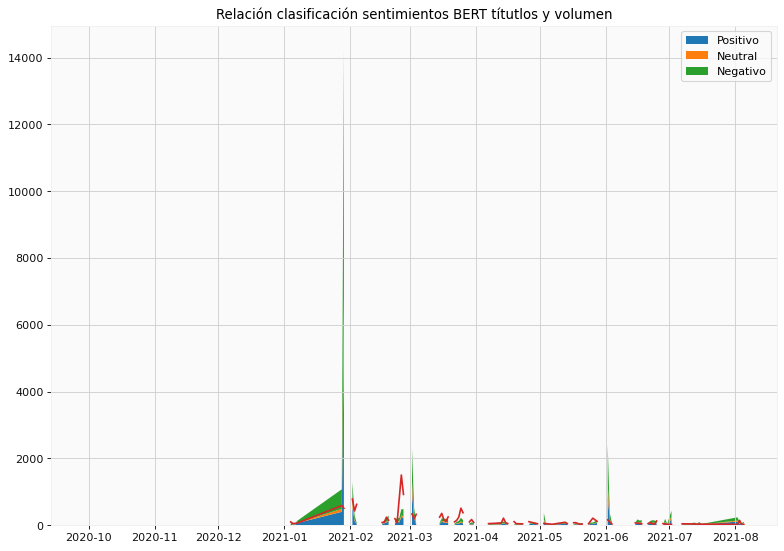

In [170]:
figure(figsize=(11.7,8.27), dpi=80)

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.BERT_title_pos, reddit_gme_date.BERT_title_neu, reddit_gme_date.BERT_title_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos BERT títutlos y volumen')

plt.show()

Repetimos la gráfica pero esta vez limitando el eje y para hacer zoom en la gráfica.

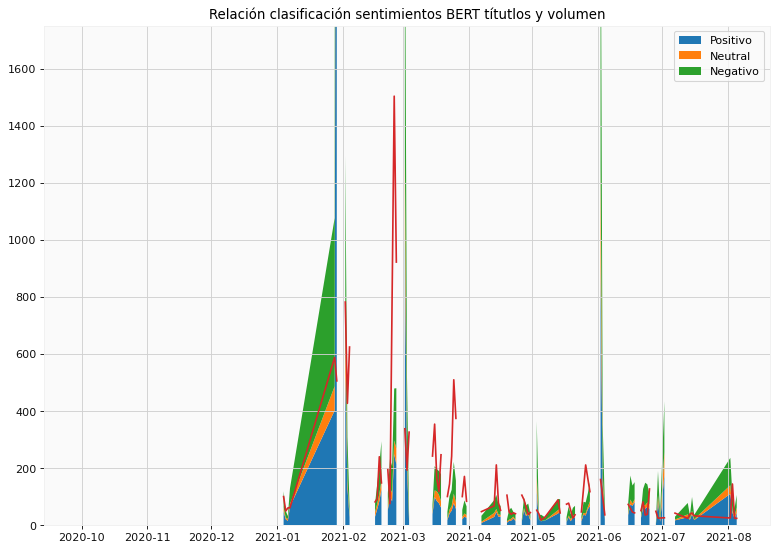

In [171]:
figure(figsize=(11.7,8.27), dpi=80)
axes = plt.gca()

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.BERT_title_pos, reddit_gme_date.BERT_title_neu, reddit_gme_date.BERT_title_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos BERT títutlos y volumen')
axes.set_ylim([0,1750])

plt.show()

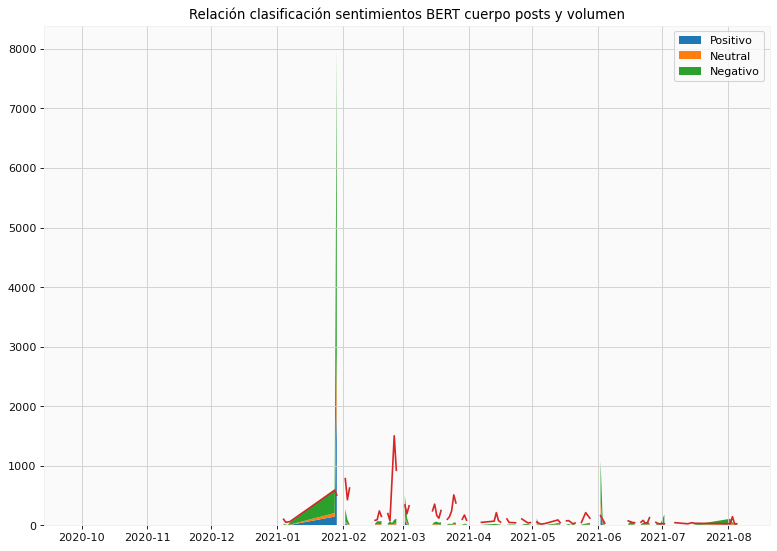

In [172]:
figure(figsize=(11.7,8.27), dpi=80)

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.BERT_body_pos, reddit_gme_date.BERT_body_neu, reddit_gme_date.BERT_body_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos BERT cuerpo posts y volumen')


plt.show()

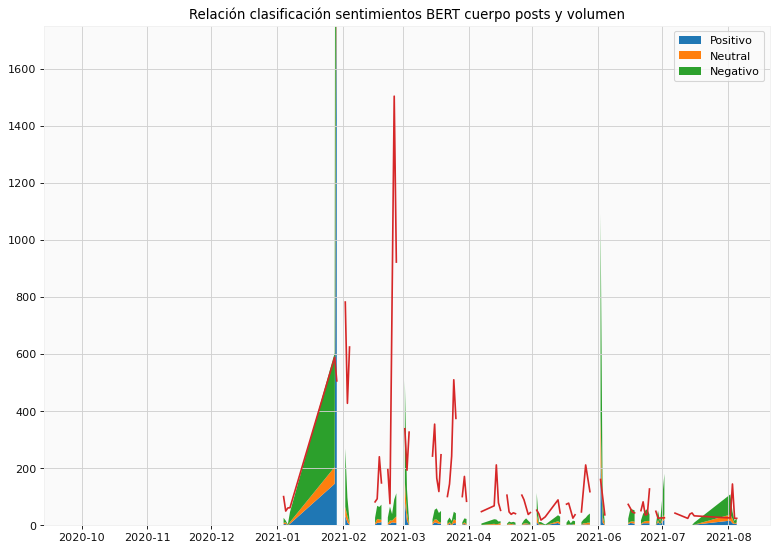

In [173]:
figure(figsize=(11.7,8.27), dpi=80)
axes = plt.gca()

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.BERT_body_pos, reddit_gme_date.BERT_body_neu, reddit_gme_date.BERT_body_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos BERT cuerpo posts y volumen')
axes.set_ylim([0,1750])

plt.show()

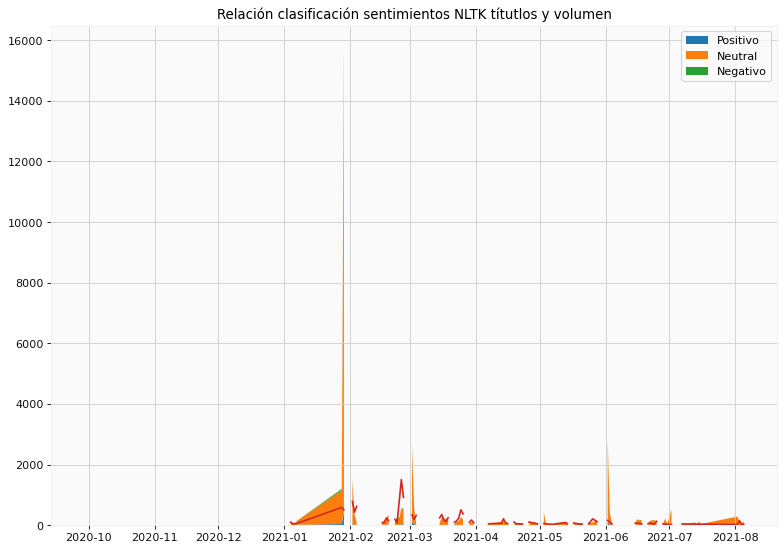

In [174]:
figure(figsize=(11.7,8.27), dpi=80)

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.nltk_title_pos, reddit_gme_date.nltk_title_neu, reddit_gme_date.nltk_title_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos NLTK títutlos y volumen')

plt.show()

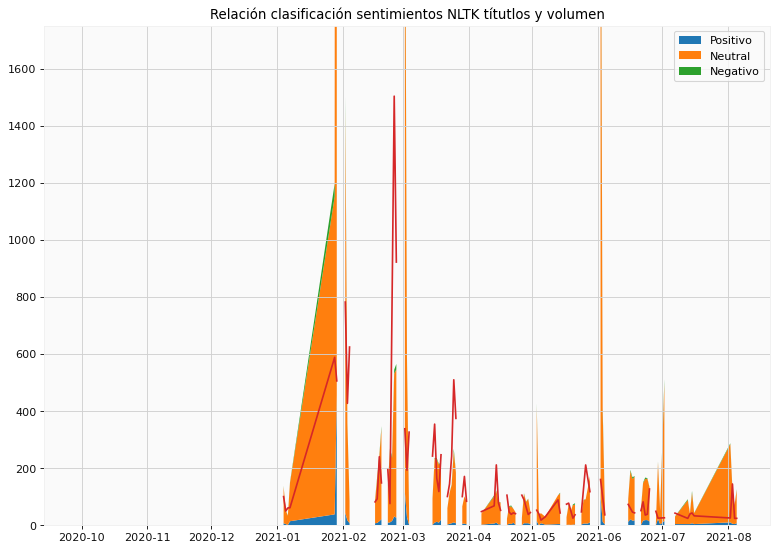

In [175]:
figure(figsize=(11.7,8.27), dpi=80)
axes = plt.gca()

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.nltk_title_pos, reddit_gme_date.nltk_title_neu, reddit_gme_date.nltk_title_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos NLTK títutlos y volumen')
axes.set_ylim([0,1750])

plt.show()

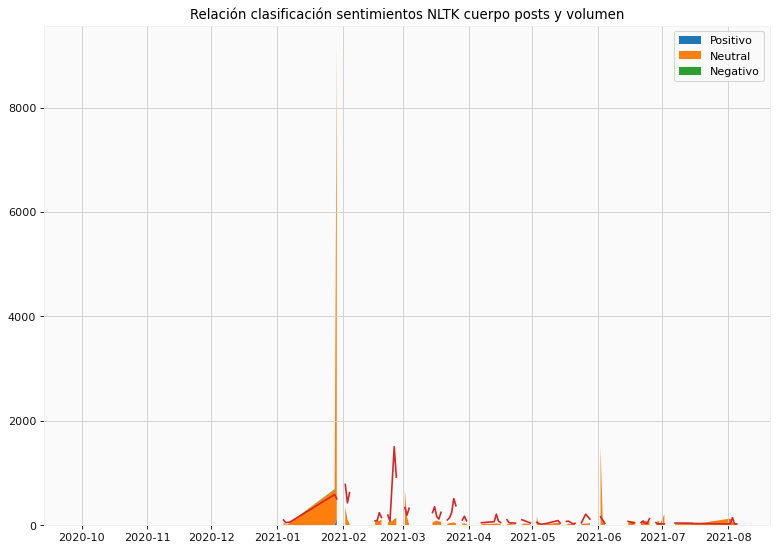

In [176]:
figure(figsize=(11.7,8.27), dpi=80)

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.nltk_body_pos, reddit_gme_date.nltk_body_neu, reddit_gme_date.nltk_body_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos NLTK cuerpo posts y volumen')


plt.show()

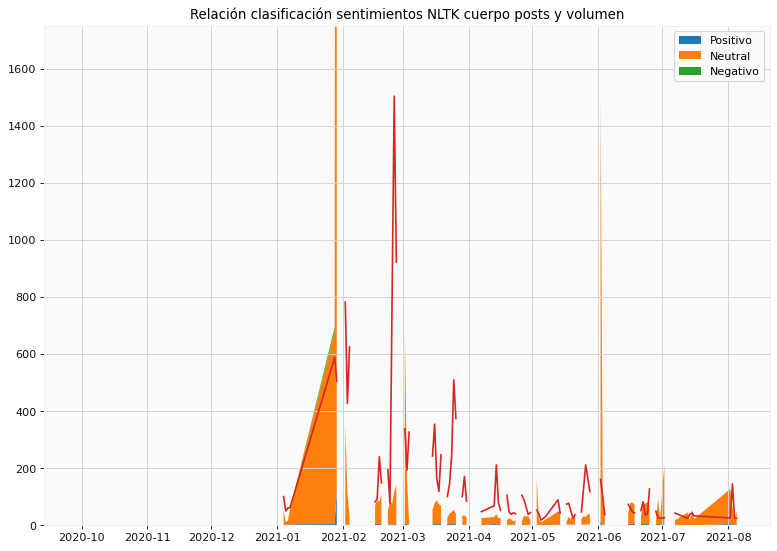

In [177]:
figure(figsize=(11.7,8.27), dpi=80)
axes = plt.gca()

plt.stackplot(reddit_gme_date.Date,reddit_gme_date.nltk_body_pos, reddit_gme_date.nltk_body_neu, reddit_gme_date.nltk_body_neg, labels=['Positivo','Neutral','Negativo'])
plt.plot(reddit_gme_date.Date, reddit_gme_date.Volume/100000)
plt.legend(loc='upper right')
plt.title('Relación clasificación sentimientos NLTK cuerpo posts y volumen')
axes.set_ylim([0,1750])


plt.show()

## 7. Conclusiones <a class="anchor" id="cap7"></a>